In [1]:
import numpy as np
import matplotlib.pyplot as plt
from python_code.nord_cmap import *
import os
from tqdm import tqdm
from load_data import *
from scipy.signal import welch
from DDMP import * 
from typing import Iterable
import shutil


In [2]:
dir_path = "/media/andrea/Crucial X6/Master/MachineLearning"

In [3]:
def compute_isotropic_psd(img : Iterable) -> tuple: 
    """
    compute_isotropic_psd compute_isotropic_psd compute isotropic power distribution of a given image

    Parameters
    ----------
    img : Iterable
        _description_

    Returns
    -------
    tuple
        tuple of Iterable (wave vector k, power vector)
    """    
    
    delta_x = 250/64
    k, p = welch(img, fs = 2 * np.pi / delta_x, axis = 0, scaling= 'spectrum', nperseg = 64)
    
    return k, np.mean(p, axis = 1)

In [4]:
data = np.load(dir_path + "/data.npy")

In [5]:
data = (data - data.min())/abs(data - data.min()).max()

In [ ]:
k,p = np.mean([compute_isotropic_psd(img) for img in data], axis = 0)
sigma_k, sigma_p = np.std([compute_isotropic_psd(img) for img in data], axis = 0)

In [37]:
k_2,p_2 = np.mean([compute_isotropic_psd(img) for img in data_new], axis = 0)
sigma_k_2, sigma_p_2 = np.std([compute_isotropic_psd(img) for img in data_new], axis = 0)

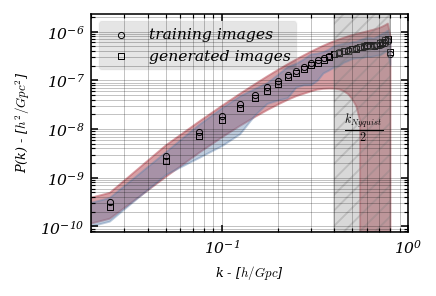

In [ ]:
fig, ax = plt.subplots(figsize = (3,2))
color = color_list(2)
k_nyquist = np.pi * 64 / 250

ax.fill_between(k,(p-sigma_p)* k ** 3, (p+sigma_p)* k ** 3, color = color[1], alpha= .6)
ax.fill_between(k_2,(p_2-sigma_p_2)* k_2 ** 3, (p_2+sigma_p_2)* k_2 ** 3, color = color[0], alpha= .4)

ax.scatter(k,p * k ** 3, s = 10, fc= (0,0,0,0), ec = 'k', label = 'training images', linewidths= .5)

ax.scatter(k_2,p_2 * k_2 ** 3, s = 10, fc = (0,0,0,0), ec = 'k', marker = 's',  label = 'generated images', linewidths=.5)


ax.legend()
ax.set_xlabel('k - [$h/Gpc$]')
ax.set_ylabel('P(k) - [$h^{2}/Gpc^2$]')
ax.tick_params(labelsize=8)
ax.grid(which = 'both', alpha = .3)
ax.axvspan(k_nyquist/2, k_nyquist, color = 'grey', alpha = .3, hatch = '///')
ax.text(k_nyquist -.35, 1e-8, '$\\frac{k_{{Nyquist}}}{2}$', fontsize = 9, rotation = 0, va = 'center', ha = 'left')
ax.set_xlim(2 * 1e-2, 1)

ax.set_yscale('log')
ax.set_xscale('log')




In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [56]:
# Defining model
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors
ddpm = MyDDPM(MyUNet(n_steps), n_steps=n_steps, min_beta=min_beta, max_beta = max_beta, device = device)

In [57]:
ddpm.load_state_dict(torch.load('/media/andrea/Crucial X6/Master/MachineLearning/ddpm_model.pt'))

<All keys matched successfully>

In [58]:
data_new = generate_new_images(ddpm=ddpm, n_samples=20, device = device)

Generating new images:   0%|          | 0/1000 [00:00<?, ?it/s]

In [59]:
data_new = data_new[:,0, : , :]

In [60]:
data_new = data_new.numpy()


In [61]:
data_new = (data_new - data_new.min())/abs(data_new - data_new.min()).max()
data_new = (data_new - .5) * 2

In [6]:
def transform(img, a):
    
    return 2 * img / (img + a) -1

In [7]:
def linear_transform(img):
    
    return (img - img.min()) / abs(img - img.min()).max()

In [22]:
a_ = [0.001, 0.01,0.1]

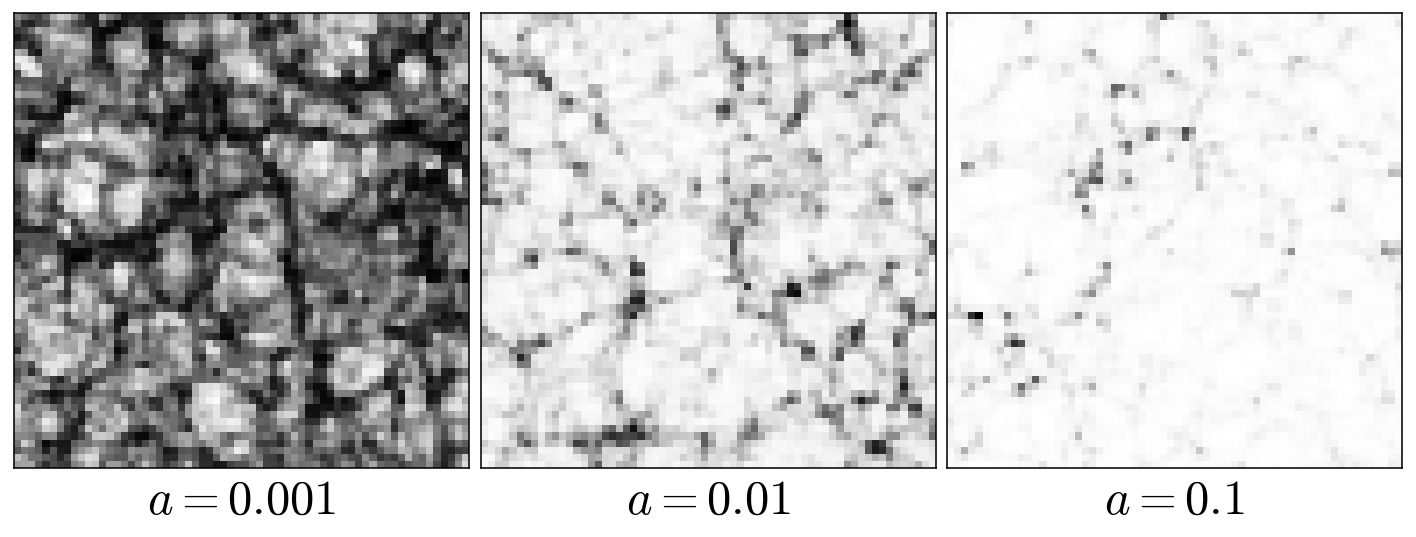

In [29]:
fig, axs = plt.subplots(1, 3, figsize = (10, 5))
for i,ax in enumerate(axs.flat) : 
    ax.imshow(transform(data[i], a_[i]), cmap = 'Greys')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('$a = {}$'.format(a_[i]), fontsize = 25)
plt.savefig('./CR/figure/img_transfo.png')

In [38]:
a_ = [0.001,0.005,0.01, 0.05, 0.1, 0.2, 0.3]

In [42]:
for a in a_ : 
    print((np.sqrt(a) - a, 1 - np.sqrt(a)))

(0.03062277660168379, 0.9683772233983162)
(0.06571067811865475, 0.9292893218813453)
(0.09000000000000001, 0.9)
(0.17360679774997895, 0.7763932022500211)
(0.21622776601683794, 0.683772233983162)
(0.24721359549995792, 0.5527864045000421)
(0.24772255750516609, 0.4522774424948339)


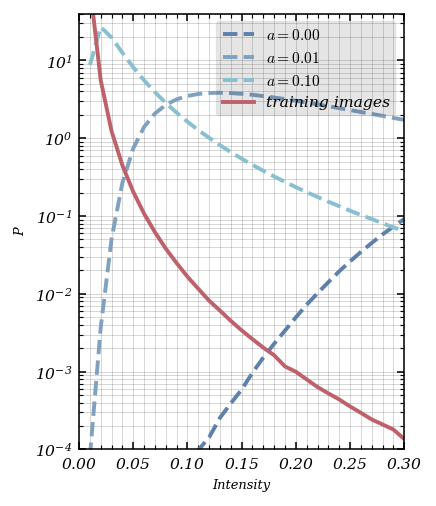

In [26]:
fig, ax = plt.subplots(1, 1, figsize = (3, 3.5))
color = color_list(8)
for i,a in enumerate(a_) : 
    
    n, bins, patch  = ax.hist(linear_transform(transform(data.flatten(),a)), bins = 100 , density = True, color = (0,0,1,.0))
    ax.plot(bins[1:], n,'--',  color = color[i], lw = 2, label = f'$a = {a:.2f}$')

n, bins, patch = ax.hist(data.flatten(), bins = 100 , density = True, color =  (0,0,1,.0))
ax.plot(bins[1:], n, color = color[-1], lw = 2, label = 'training images')
ax.set_yscale('log')
ax.legend(loc = 'upper right')
ax.set_ylim(1e-4, 4e1)
ax.set_xlim(0,0.3)
ax.grid(which = 'both', alpha = .2)
ax.set_xlabel('Intensity')
ax.set_ylabel('P')
plt.savefig('./CR/figure/distr_transfo.png')

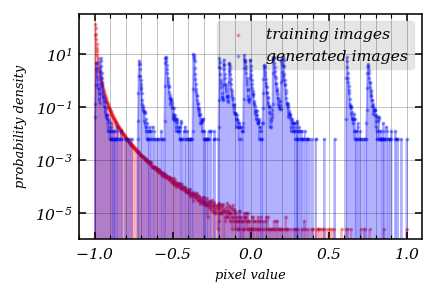

In [19]:
fig, ax = plt.subplots(1, 1, figsize = (3, 2))
n, bins, patch = ax.hist(data.flatten(), bins = 1000 , density = True, color = (0,0,1,.0))
n_2, bins_2, patch_2 = ax.hist(data_new.flatten(), bins = 1000, density = True, color = (1,0,0,.0))

ax.scatter(bins[1:], n, s = 1, ec = 'r', fc = None, alpha = .3, label = 'training images')
ax.fill_between(bins[1:], n,0, color = 'r', alpha = .3)

ax.scatter(bins_2[1:], n_2, s = 1, ec = 'b', fc = None, alpha = .3, label = 'generated images')
ax.fill_between(bins_2[1:], n_2,0, color = 'b', alpha = .3)

ax.grid(which='both', alpha = .3)
ax.set_yscale("log")
ax.set_xlabel('pixel value')
ax.set_ylabel('probability density')
ax.legend()

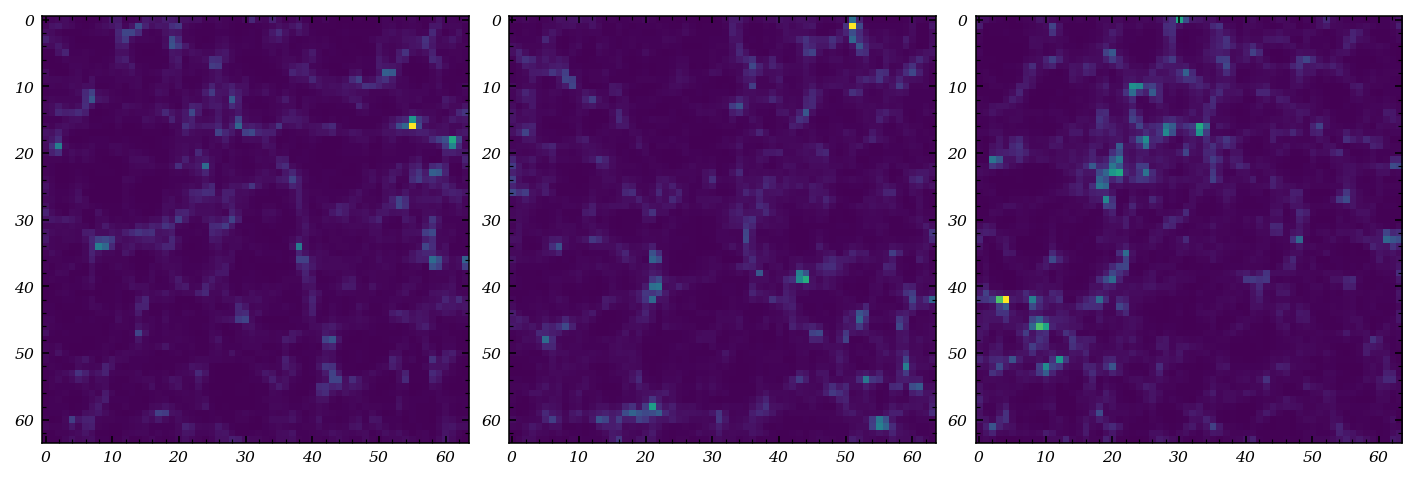

In [25]:
data2 = data_new[0,0]
fig, ax = plt.subplots(1,3,figsize = (10, 5))
ax[0].imshow(data[0])
ax[1].imshow(data[1])
ax[2].imshow(data[2])

plt.savefig(dir_path + '/CR/figure/training_image.png', dpi = 300)

In [62]:
def galaxy_neighboors(img, threshold = 0.1):
    
    img = abs(img - img.min())
    flat = np.zeros((len(img)**2, len(img)**2))

    for i in range(len(img)) : 
        for j in range(len(img)) : 
            
            if (i == 0) or (i == 63) or (j == 0) or (j == 63) : 
                pass
            
            else : 
                
                flat[i*64 + j, (i-1)*64 + j-1] = img[i-1, j-1] > threshold * img.max()
                flat[i*64 + j, (i-1)*64 + j] = img[i-1, j] > threshold * img.max()
                flat[i*64 + j, (i-1)*64 + j+1] = img[i-1, j+1]  > threshold * img.max()
                flat[i*64 + j, i*64 + j-1] = img[i, j-1]  > threshold * img.max()
                flat[i*64 + j, i*64 + j] = img[i, j]  > threshold * img.max()
                flat[i*64 + j, i*64 + j+1] = img[i, j+1] > threshold * img.max()
                flat[i*64 + j, (i+1)*64 + j-1] = img[i+1, j-1] > threshold * img.max()
                flat[i*64 + j, (i+1)*64 + j] = img[i+1, j] > threshold * img.max()

    return flat

In [63]:
ng = galaxy_neighboors(data[0], threshold= .05)

In [64]:
zeros = np.argwhere(ng.sum(axis = 1) == 0)

In [65]:
import networkx as nx

graph = nx.from_numpy_array(ng)
graph.remove_nodes_from(list(zeros[:,0]))

In [66]:
co = sorted(nx.connected_components(graph), key = len, reverse=True)

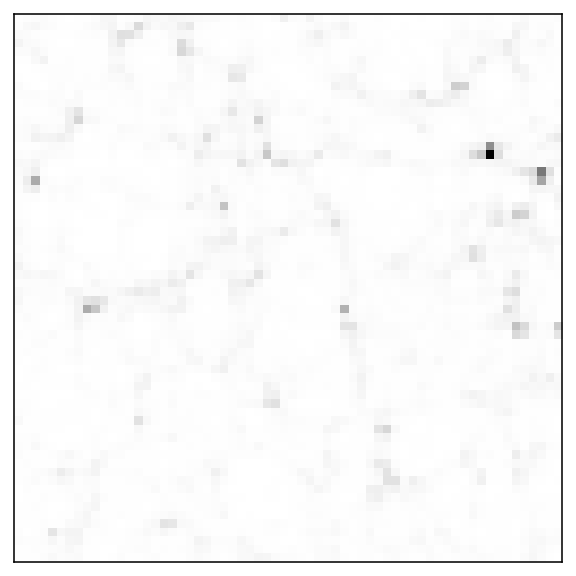

In [200]:
fig, ax = plt.subplots(1, figsize = (4,4))
ax.imshow(data[0], cmap = 'Greys')

ax.set_xticks([])
ax.set_yticks([])
plt.savefig('./CR/figure/generated_image_cluster')

In [112]:
 np.concatenate(total_coords, axis = 1)

57

In [109]:
np.concatenate(total_coords, axis = 1)

array([[ 5,  6,  7, ..., 62, 29, 30],
       [32, 32, 32, ..., 38, 62, 62]])

In [18]:
def compute_filaments_spreading(graph : nx.Graph) -> Iterable : 
    
    co = sorted(nx.connected_components(graph), key = len, reverse=True)
    delta = []
    for i, coord in enumerate(co) : 
        
        coords = np.array(list(coord))
        x,y = coords % 64, coords // 64
        
        delta_x, delta_y = x.max() - x.min(), y.max() - y.min()
        delta.append([delta_x, delta_y])
        

    return delta

In [24]:
rand = np.random.randn(20, 64, 64)
rand = (rand - rand.min())/abs(rand - rand.min()).max()

/tmp/ipykernel_14144/604491256.py:15: RuntimeWarning: invalid value encountered in divide
  ax.hist(np.array(delta)[:,0]/ np.array(delta)[:,1], bins = 40, alpha = .5, label = 'test dist', density = True)
/tmp/ipykernel_14144/604491256.py:36: RuntimeWarning: invalid value encountered in divide
  ax.hist(np.array(delta_3)[:,0] / np.array(delta_3)[:,1], bins = 40, alpha = .5, label = 'gaussian dist', density = True)


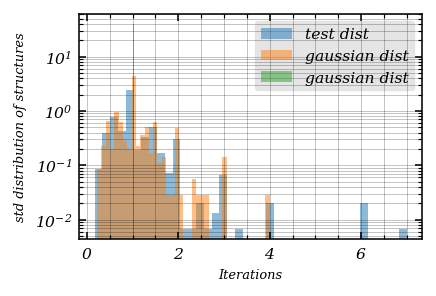

In [27]:
fig, ax = plt.subplots(figsize = (3, 2))

delta = compute_filaments_spreading(graph)

for k in range(1,20) : 
    
    ng = galaxy_neighboors(data[k], threshold= .05)
    zeros = np.argwhere(ng.sum(axis = 1) == 0)
    graph = nx.from_numpy_array(ng)
    graph.remove_nodes_from(list(zeros[:,0]))
    delta_2 = compute_filaments_spreading(graph)
    delta = np.concatenate([delta, delta_2], axis = 0)


ax.hist(np.array(delta)[:,0]/ np.array(delta)[:,1], bins = 40, alpha = .5, label = 'test dist', density = True)
ax.set_yscale("log")
ax.grid(which='both', alpha = .3)



ng = galaxy_neighboors(data_new[0], threshold= .05)
zeros = np.argwhere(ng.sum(axis = 1) == 0)
graph = nx.from_numpy_array(ng)
graph.remove_nodes_from(list(zeros[:,0]))
delta_3 = compute_filaments_spreading(graph)

for k in range(1,19) : 
    
    ng = galaxy_neighboors(data_new[k], threshold= .05)
    zeros = np.argwhere(ng.sum(axis = 1) == 0)
    graph = nx.from_numpy_array(ng)
    graph.remove_nodes_from(list(zeros[:,0]))
    delta_4 = compute_filaments_spreading(graph)
    delta_3 = np.concatenate([delta_3, delta_4], axis = 0)

ax.hist(np.array(delta_3)[:,0] / np.array(delta_3)[:,1], bins = 40, alpha = .5, label = 'gaussian dist', density = True)
ax.set_ylabel('std distribution of structures')
ax.set_xlabel('Iterations')
ax.legend()



ng = galaxy_neighboors(rand[0], threshold= .05)
zeros = np.argwhere(ng.sum(axis = 1) == 0)
graph = nx.from_numpy_array(ng)
graph.remove_nodes_from(list(zeros[:,0]))
delta_5 = compute_filaments_spreading(graph)

for k in range(1,19) : 
    
    ng = galaxy_neighboors(rand[k], threshold= .05)
    zeros = np.argwhere(ng.sum(axis = 1) == 0)
    graph = nx.from_numpy_array(ng)
    graph.remove_nodes_from(list(zeros[:,0]))
    delta_6 = compute_filaments_spreading(graph)
    delta_5 = np.concatenate([delta_5, delta_6], axis = 0)


ax.hist(np.array(delta_5)[:,0] / np.array(delta_5)[:,1], bins = 40, alpha = .5, label = 'gaussian dist', density = True)
ax.set_ylabel('P')
ax.set_xlabel('std distribution of structures')
ax.legend()



In [12]:
prim_imgs = np.load('df_m_64_PCS_z=127.npy')
data_prim = np.array([np.mean(prim_imgs[:,:,k:k+2], axis = 2) for k in range(len(prim_imgs) - 1)])
data_prim = (data_prim - data_prim.min())/abs(data_prim - data_prim.min()).max()

In [172]:
data_prim.min()

0.0

In [26]:
from scipy.optimize import curve_fit

def gaussian(x,mean, std) :
    
    return 1/ np.sqrt(2 * np.pi * std **2) * np.exp(-(x-mean) **2 / (2* std**2)) 

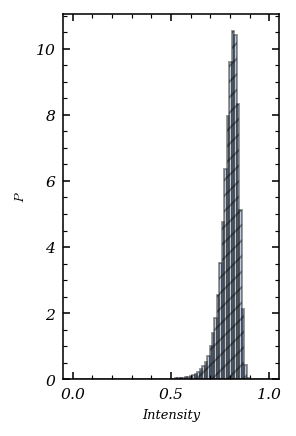

In [179]:
fig, ax = plt.subplots(figsize = (2,3))
color = color_list(2)
data_prim_2 = 2 * data_prim/(data_prim + .05) - 1
n, bins, patch = ax.hist(data_prim_2.flatten(), density = True, bins = np.linspace(0,1,80), alpha = .4, color = color[0], ec = 'k', hatch = '///')
ax.set_ylabel('$P$')
ax.set_xlabel('Intensity')
x = np.linspace(0,1,200)


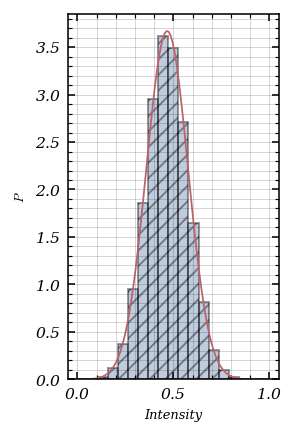

In [49]:
fig, ax = plt.subplots(figsize = (2,3))
color = color_list(2)
n, bins, patch = ax.hist(data_prim.flatten(), density = True, bins = np.linspace(0,1,20), alpha = .4, color = color[0], ec = 'k', hatch = '///')
p_opt, p_cov = curve_fit(gaussian,( bins[1:] + bins[:-1])/2, n, p0 = [.5, .1])
x = np.linspace(0,1,100)
ax.plot(x, gaussian(x, *p_opt), lw = .9, color = color[1])
ax.grid(which = 'both', alpha = .2)
ax.set_ylabel('$P$')
ax.set_xlabel('Intensity')
plt.savefig('./CR/figure/density_prim')